# Train notebook for focusfinder

Last tutorial on this page should be exactly whats needed

https://docs.fast.ai/tutorial.vision

In [1]:
from fastai.vision.all import *

### All current imgs (244px)

In [79]:
path = Path('../')
labels_path = path/'download/labels/train_labels.csv'
images_path = path/'download/images/norm_images'

### 100 imgs paths

In [2]:
path = Path('../')
labels_path = path/'download/labels/100_norm_imgs.csv'
images_path = path/'download/100_norm_images'

In [ ]:
path = Path('../')
labels_path = path/'download/labels/100_.csv'
images_path = path/'download/images/norm_images'

### 4000 imgs paths (256px)

In [5]:
path = Path('../')
labels_path = path/'download/labels/norm_labels_4000_256px.csv'
images_path = path/'download/images/norm_images_256'

### load labels csv

In [80]:
df = pd.read_csv(labels_path) #names=['name','x_p','y_p'], header=0)

In [82]:
df.head()

,Unnamed: 0,name,x_p,y_p,Unnamed: 0.1
0,0,0a0c1f65f19859c0.jpg,108.986667,53.680000,NaN
1,1,0a1dae8f71065201.jpg,118.340000,94.663120,NaN
2,2,0a1efc8533c96832.jpg,134.581250,105.606391,NaN
3,3,0a2ca221284ab461.jpg,95.104004,83.792095,NaN
4,4,0a3cf18c620e6a88.jpg,99.738574,94.861944,NaN


### define label function
Function is needed that takes the file_name as input and returns the focus point of the corresponing image

In [39]:
re.search(r'\w+.jpg', str(path_name)).group()

'asdf/haaasdhg.jpg'

In [83]:
import re

def get_focus_point(path_name):
    dfb = next(iter(df[df['name']==path_name.name].index), ('no match for '+path_name.name))
    return tensor([float(df['x_p'][dfb]), float(df['y_p'][dfb])])

In [84]:
# check if there are matches for each file
img_files = get_image_files(images_path)
for __img in img_files:
    get_focus_point(__img)

### create datablock and dataloader

In [85]:
imgs = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_focus_point,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=[*aug_transforms(size=(244, 244)),
                Normalize.from_stats(*imagenet_stats)],
    item_tfms=Resize(244),
)

In [86]:
dls = imgs.dataloaders(images_path, bs=32)

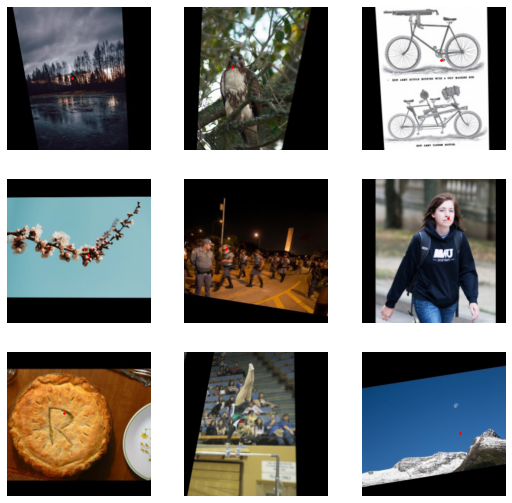

In [91]:
dls.show_batch()

### create model and train

In [92]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
# try other models

In [93]:
# only helper for vscode, so that the output bars from fastai do not get removed when the cell is done
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=3.630780702224001e-05)

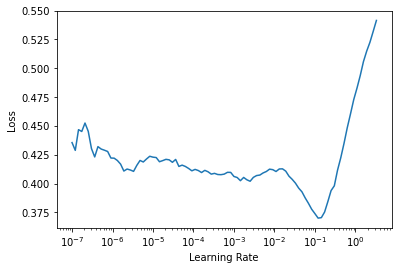

In [95]:
learn.lr_find()

In [94]:
learn.fine_tune(1, 2e-5) # 5e-3
# RETRAIN LATER

epoch,train_loss,valid_loss,time
0,0.417985,0.237045,19:02


### test model

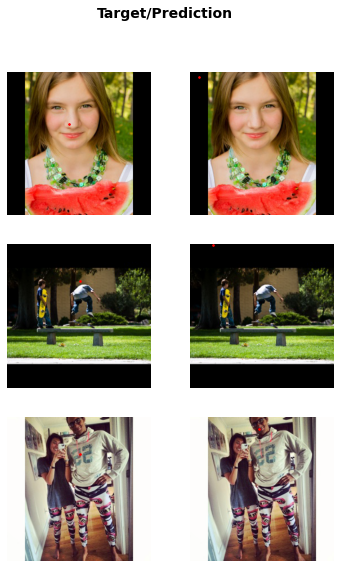

In [14]:
learn.show_results()

In [15]:
preds, y = learn.get_preds()

distances = []
for _p, _y in zip(preds, y):
    d = np.linalg.norm(_p-_y[0])
    distances.append(d)

mean = np.mean(distances)
print('The mean is {:.2f} or {:.2f} px'.format(mean, (mean*256)))
# std_dev = 

### export model

In [13]:
learn.export('./models/focusfinder_4000_2e-5.pkl')

## load trained model
---

In [13]:
# if model is already trained
model = load_learner('models/2020115221815-30epochs-0.0002trainrate_model.pkl')

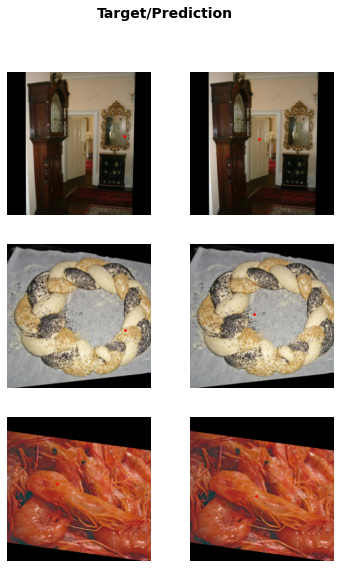

In [23]:
model.show_results(dl=dls)

In [15]:
preds, y = model.get_preds(dl=dls)

distances = []
for _p, _y in zip(preds, y):
    d = np.linalg.norm(_p-_y[0])
    distances.append(d)

mean = np.mean(distances)
print('The mean is {:.2f} or {:.2f} px'.format(mean, (mean*256)))
# std_dev = 

# Summary

- learn_rate: 5e-3 ~5 epochs (focusfinder_4000_5e-3.pkl)
    - The mean is 0.23 or 59.97 px
- learn_rate: 2e-5 ~10 epochs (focusfinder_4000_2e-5.pkl))
    - The mean is 0.63 or 161.16 px
- 2020115221815-30epochs-0.0002trainrate_model.pkl
    - The mean is 0.28 or 70.99 px